In [ ]:
import pandas
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import calendar

In [ ]:
def crateBaseTabe(listingPath, reviewsPath, year):
    """
    Creates a table that can be process by CreateCalendar. It will create the table for a specific year.
    :param listingPath: the smaller listing.csv file
    :param reviewsPath: the review.csv file
    :return: a table with listing_id, date, minimum_nights, price, adjusted_price, maximum_nights
    """

    tempListing = pandas.read_csv(listingPath)
    dataframeReviews = pandas.read_csv(reviewsPath)
    # # get rid of not needed columns and rows.
    dataframeReviews = dataframeReviews[dataframeReviews["comments"].str.contains("This is an automated posting") == False]
    dataframeReviews = dataframeReviews.drop('id', axis=1)
    dataframeReviews = dataframeReviews.drop('reviewer_id', axis=1)
    dataframeReviews = dataframeReviews.drop('reviewer_name', axis=1)
    dataframeReviews = dataframeReviews.drop('comments', axis=1)
    dataframeReviews = dataframeReviews[dataframeReviews['date'].astype("string").str.contains(year)==True]
    #creating the tabel with the right columns and joining the tables with a left join on id/listing_id.
    dataframeListing = pandas.DataFrame()
    dataframeListing['listing_id'] = tempListing['id']
    dataframeListing['price'] = tempListing ['price']
    dataframeListing['adjusted_price'] = tempListing ['price']
    dataframeListing['minimum_nights'] = tempListing['minimum_nights']
    dataframeListing['maximum_nights'] = tempListing['minimum_nights']
    # joining the tables with a left join on id
    table = pandas.merge(dataframeReviews, dataframeListing, how="left", on=["listing_id"])
    return table

def createTabelObjekt(listing_id, dateOfBooking, minimum_nights, price, adjusted_price, maximum_nights, year):
    """
    This function creates, for a given apartment, a table with the availability.
    :param year: the year of the table
    :param listing_id: the apartment ID as a string
    :param dateOfBooking: an index with the booking — see notAvailabilityList for the format.
    :param minimum_nights: Sting
    :param price: Sting
    :param adjusted_price: Sting
    :param maximum_nights: Sting
    :return: a table with available of the appartment for each day
    """


    def calculateAvailabile(dateList):
        """
        This function checks the dateOfBooking list and calculate the occupied days
        :param dateList: the list
        :return: list of unavailable days
        """
        #print(dateList)
        falseDates = []
        for j in dateList:
            if j[1] != 0:
                for k in range(int(j[1])):
                    falseDates.append(str((datetime.strptime(j[0], '%Y-%m-%d')+ timedelta(days=k)).date()))
        return falseDates

    def printIfAvailabil(day):
        """
        This function checks if a day is Anabel or not.
        :param day: the day should be checked as str (YYYY-MM-DD)
        :return: t for an available day and f for an unavailable day
        """
        if str(day) in notAvailabileDays:
            return 'f'
        else:
            return 't'
    # call of the helper function
    notAvailabileDays = calculateAvailabile (dateOfBooking)
    # leap year?
    yearDayCounter = 365 + calendar.isleap(int(year))
    # crating the table that will be returned
    collumsNames = {'listing_id': [], 'date': [], 'available':[], 'price':[], 'adjusted_price':[], 'minimum_nights':[], 'maximum_nights':[]}
    for i in range(yearDayCounter):
        k = printIfAvailabil((datetime.strptime((year+"-01-01"), '%Y-%m-%d')+ timedelta(days=i)).date())
        collumsNames['listing_id'].append(listing_id)
        collumsNames['date'].append((datetime.strptime((year+"-01-01"), '%Y-%m-%d')+ timedelta(days=i)).date())
        collumsNames['available'].append(k)
        collumsNames['price'].append(price)
        collumsNames['adjusted_price'].append(adjusted_price)
        collumsNames['minimum_nights'].append(minimum_nights)
        collumsNames['maximum_nights'].append(maximum_nights)

    returnTabel = pandas.DataFrame(collumsNames)
    return returnTabel

def notAvailabilityList(appartment, df, mode):
    """
    This function returns the list if bookings for an given appartment
    :param appartment: the id of the appartment
    :param df: the reviews dataframe
    :return: a list of bookings for the minimum nights
    """


    tempList = []
    for index in appartment:
        row = df.iloc[index]
        date = row['date']
        minStay = row[mode]
        tempList.append((date,minStay))
    return tempList

#that is the call --->(createTabelObjekt('123', {'2022-09-27' : 5}, '3','300','300','100','2019'))
def plotPastAvailability(listing, reviews, year, savePath, mode):
    """
    This is the control function for the calculation and the plotting
    :param listing: path to the listing file
    :param reviews: path to the reviews file
    :param year: the year of the plot
    :param savePath: the saving path for the plot
    :return: a plot as svg to the given path and the plt object
    """
    df = crateBaseTabe(listing, reviews, year)
    # all id of apartments
    appartmentId = df['listing_id'].unique().tolist()
    returnTable = pandas.DataFrame()
    #iterrating over the unique list of apartments.
    for appartment in appartmentId:
        indexList = df[df['listing_id']==appartment].index.values
        notAvailability = notAvailabilityList(indexList, df, mode)
        appartmentData = createTabelObjekt(appartment, notAvailability, df.iloc[indexList[0],0], df.iloc[indexList[0],0], df.iloc[indexList[0],0], df.iloc[indexList[0],0], year)
        returnTable = returnTable.append(appartmentData, ignore_index=True)
        #print('objekt ', appartment, " is done")
    # creating the Pivod table for the plot
    dataframePivod = pandas.get_dummies(returnTable.pivot(index="date", columns="listing_id", values="available"), prefix_sep='', prefix='').sum(axis=1, level=0)
    dataframePivod['t'].plot()

    plt.xticks(rotation=90)
    # saving the plot
    plt.savefig(savePath, transparent=True, dpi=600)

    plt.show()
    return plt

#Oslo data

In [ ]:
smallListing = '../../data/Oslo/SmalListings.csv'
reviews = '../../data/Oslo/reviews.csv' # fot the minimum_nights
reviewsModified = '../../data/Oslo/reviews_modified.csv' # fot the estimated_nights and days_occupied
outPath = '../../data/Oslo/out/'
# lower -> minimum_nights educatedGuess -> estimated_nights NLP -> days_occupied

#plotPastAvailability(smallListing, reviewsModified, '2011',outPath+'minimum_nights/2011.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2012',outPath+'minimum_nights/2012.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2013',outPath+'minimum_nights/2013.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2014',outPath+'minimum_nights/2014.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2015',outPath+'minimum_nights/2015.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2016',outPath+'minimum_nights/2016.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2017',outPath+'minimum_nights/2017.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2018',outPath+'minimum_nights/2018.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2019',outPath+'minimum_nights/2019.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2020',outPath+'minimum_nights/2020.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2021',outPath+'minimum_nights/2021.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2022',outPath+'minimum_nights/2022.svg',  'minimum_nights' )

plotPastAvailability(smallListing, reviewsModified, '2011',outPath+'estimated_nights/2011.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2012',outPath+'estimated_nights/2012.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2013',outPath+'estimated_nights/2013.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2014',outPath+'estimated_nights/2014.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2015',outPath+'estimated_nights/2015.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2016',outPath+'estimated_nights/2016.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2017',outPath+'estimated_nights/2017.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2018',outPath+'estimated_nights/2018.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2019',outPath+'estimated_nights/2019.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2020',outPath+'estimated_nights/2020.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2021',outPath+'estimated_nights/2021.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2022',outPath+'estimated_nights/2022.svg',  'estimated_nights' )

plotPastAvailability(smallListing, reviewsModified, '2011',outPath+'days_occupied/2011.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2012',outPath+'days_occupied/2012.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2013',outPath+'days_occupied/2013.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2014',outPath+'days_occupied/2014.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2015',outPath+'days_occupied/2015.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2016',outPath+'days_occupied/2016.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2017',outPath+'days_occupied/2017.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2018',outPath+'days_occupied/2018.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2019',outPath+'days_occupied/2019.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2020',outPath+'days_occupied/2020.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2021',outPath+'days_occupied/2021.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2022',outPath+'days_occupied/2022.svg',  'days_occupied' )

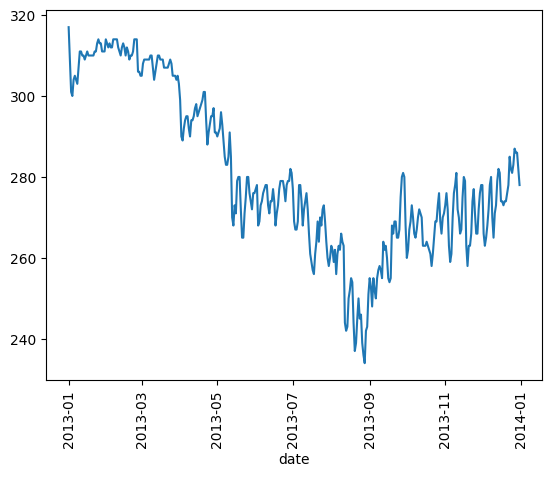

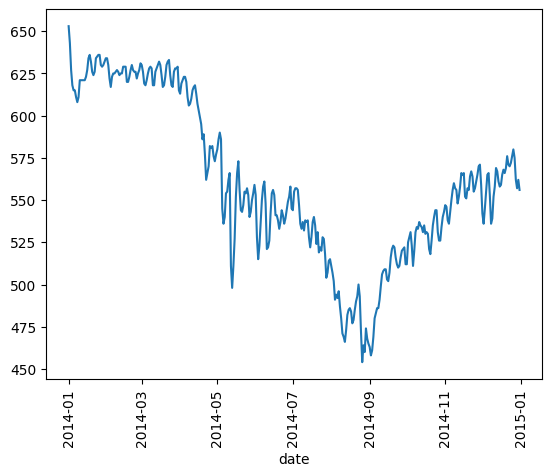

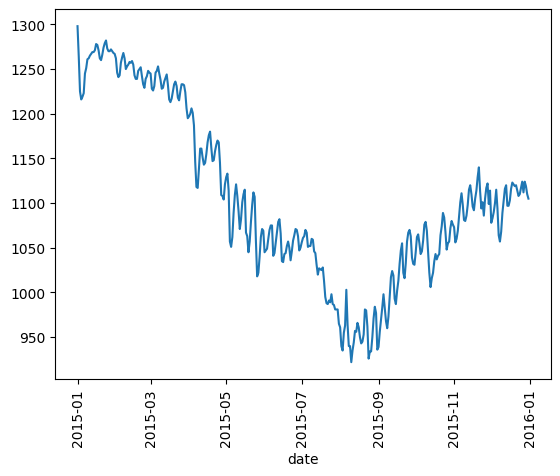

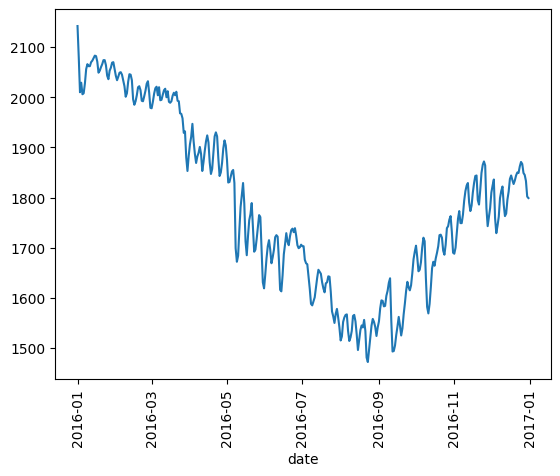

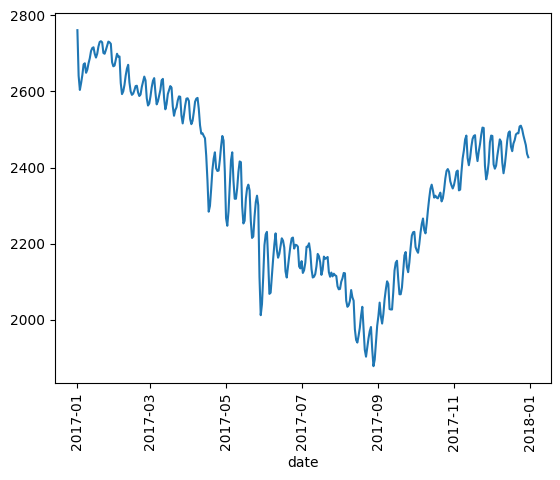

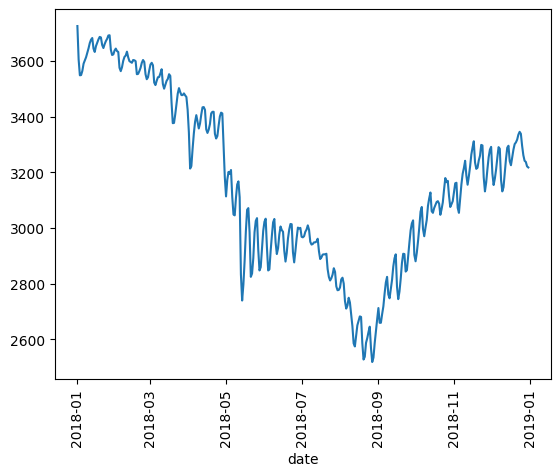

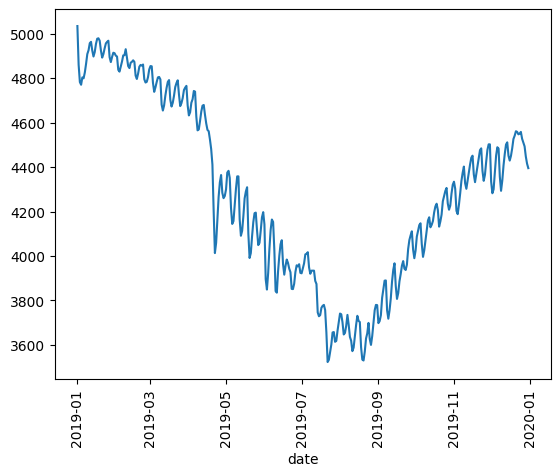

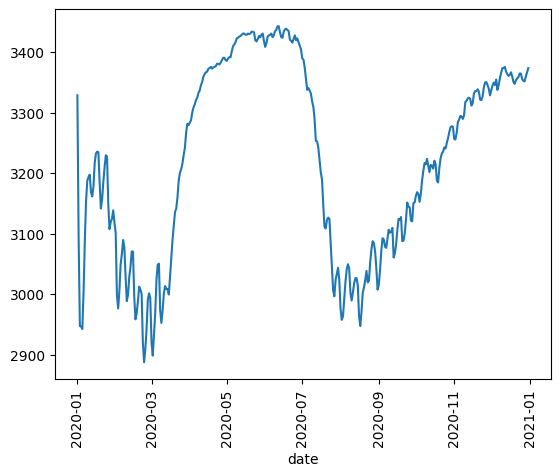

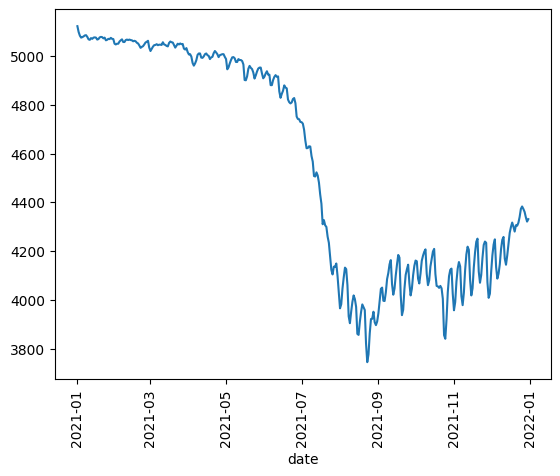

<module 'matplotlib.pyplot' from '/Users/andreas/Documents/Lernen/Studium/Bachelor/Module Semester 6/Python /repo/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [30]:
smallListing = '../../data/Copenhagen/SmalListings.csv'
reviews = '../../data/Copenhagen/reviews.csv' # fot the minimum_nights
reviewsModified = '../../data/Copenhagen/reviews_modified.csv' # fot the estimated_nights and days_occupied
outPath = '../../data/Copenhagen/out/'
# lower -> minimum_nights educatedGuess -> estimated_nights NLP -> days_occupied

#plotPastAvailability(smallListing, reviewsModified, '2009',outPath+'minimum_nights/2011.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2010',outPath+'minimum_nights/2012.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2011',outPath+'minimum_nights/2011.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2012',outPath+'minimum_nights/2012.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2013',outPath+'minimum_nights/2013.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2014',outPath+'minimum_nights/2014.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2015',outPath+'minimum_nights/2015.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2016',outPath+'minimum_nights/2016.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2017',outPath+'minimum_nights/2017.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2018',outPath+'minimum_nights/2018.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2019',outPath+'minimum_nights/2019.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2020',outPath+'minimum_nights/2020.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2021',outPath+'minimum_nights/2021.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2022',outPath+'minimum_nights/2022.svg',  'minimum_nights' )

#plotPastAvailability(smallListing, reviewsModified, '2009',outPath+'estimated_nights/2011.svg',  'estimated_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2010',outPath+'estimated_nights/2012.svg',  'estimated_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2011',outPath+'estimated_nights/2011.svg',  'estimated_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2012',outPath+'estimated_nights/2012.svg',  'estimated_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2013',outPath+'estimated_nights/2013.svg',  'estimated_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2014',outPath+'estimated_nights/2014.svg',  'estimated_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2015',outPath+'estimated_nights/2015.svg',  'estimated_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2016',outPath+'estimated_nights/2016.svg',  'estimated_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2017',outPath+'estimated_nights/2017.svg',  'estimated_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2018',outPath+'estimated_nights/2018.svg',  'estimated_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2019',outPath+'estimated_nights/2019.svg',  'estimated_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2020',outPath+'estimated_nights/2020.svg',  'estimated_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2021',outPath+'estimated_nights/2021.svg',  'estimated_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2022',outPath+'estimated_nights/2022.svg',  'estimated_nights' )


plotPastAvailability(smallListing, reviewsModified, '2009',outPath+'days_occupied/2011.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2010',outPath+'days_occupied/2012.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2011',outPath+'days_occupied/2011.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2012',outPath+'days_occupied/2012.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2013',outPath+'days_occupied/2013.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2014',outPath+'days_occupied/2014.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2015',outPath+'days_occupied/2015.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2016',outPath+'days_occupied/2016.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2017',outPath+'days_occupied/2017.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2018',outPath+'days_occupied/2018.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2019',outPath+'days_occupied/2019.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2020',outPath+'days_occupied/2020.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2021',outPath+'days_occupied/2021.svg',  'days_occupied' )

In [ ]:
smallListing = '../../data/Stockholm/SmalListings.csv'
reviews = '../../data/Stockholm/reviews.csv' # fot the minimum_nights
reviewsModified = '../../data/Stockholm/reviews_modified.csv' # fot the estimated_nights and days_occupied
outPath = '../../data/Stockholm/out/'
# lower -> minimum_nights educatedGuess -> estimated_nights NLP -> days_occupied

#plotPastAvailability(smallListing, reviewsModified, '2011',outPath+'minimum_nights/2011.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2012',outPath+'minimum_nights/2012.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2013',outPath+'minimum_nights/2013.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2014',outPath+'minimum_nights/2014.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2015',outPath+'minimum_nights/2015.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2016',outPath+'minimum_nights/2016.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2017',outPath+'minimum_nights/2017.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2018',outPath+'minimum_nights/2018.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2019',outPath+'minimum_nights/2019.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2020',outPath+'minimum_nights/2020.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2021',outPath+'minimum_nights/2021.svg',  'minimum_nights' )
#plotPastAvailability(smallListing, reviewsModified, '2022',outPath+'minimum_nights/2022.svg',  'minimum_nights' )

plotPastAvailability(smallListing, reviewsModified, '2011',outPath+'estimated_nights/2011.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2012',outPath+'estimated_nights/2012.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2013',outPath+'estimated_nights/2013.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2014',outPath+'estimated_nights/2014.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2015',outPath+'estimated_nights/2015.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2016',outPath+'estimated_nights/2016.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2017',outPath+'estimated_nights/2017.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2018',outPath+'estimated_nights/2018.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2019',outPath+'estimated_nights/2019.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2020',outPath+'estimated_nights/2020.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2021',outPath+'estimated_nights/2021.svg',  'estimated_nights' )
plotPastAvailability(smallListing, reviewsModified, '2022',outPath+'estimated_nights/2022.svg',  'estimated_nights' )

plotPastAvailability(smallListing, reviewsModified, '2011',outPath+'days_occupied/2011.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2012',outPath+'days_occupied/2012.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2013',outPath+'days_occupied/2013.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2014',outPath+'days_occupied/2014.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2015',outPath+'days_occupied/2015.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2016',outPath+'days_occupied/2016.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2017',outPath+'days_occupied/2017.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2018',outPath+'days_occupied/2018.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2019',outPath+'days_occupied/2019.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2020',outPath+'days_occupied/2020.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2021',outPath+'days_occupied/2021.svg',  'days_occupied' )
plotPastAvailability(smallListing, reviewsModified, '2022',outPath+'days_occupied/2022.svg',  'days_occupied' )

In [ ]:
plotPastAvailability(smallListing, reviewsModified, '2011',outPath+'estimated_nights/2011__.svg',  'estimated_nights' )